<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Проектное задание. Сегментация изображений</b></h3>


В данном проекте создаются, обучаются и проверяются нейронные сети сегментации изображений кожных нарушений

## Цель задания
Опробовать различные модели глубокого машинного обучения
Оценить какие из моделей дают более точные результаты,
Какие быстрее обучаются и какие быстрее дают свои предсказания

---


1. Для начала скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>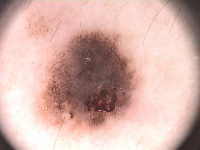</td><td>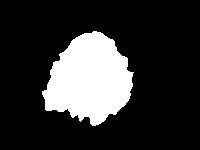</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [46]:
import numpy as np
import torch

In [47]:
%%capture
import os
import platform
folder_name   = 'PH2Dataset'
images_dir    = f'./{folder_name}'
archive_name = f"{folder_name}.rar"
archive_url  = f"https://www.dropbox.com/s/8lqrloi0mxj2acu/{archive_name}" # или https://www.kaggle.com/datasets/kanametov/ph2dataset

In [48]:
%%capture
if os.path.exists(images_dir):
    path = images_dir
else:
    if platform.system().lower().startswith('win'):
        !wsl wget "{archive_url}"
        !mkdir "{images_dir}"
        !wsl unrar x "{archive_name}" 
        path = {images_dir}
    else:
        !wget {archive_url}
        !unrar x {archive_name}
        path = {images_dir}

In [49]:
if platform.system().lower().startswith('win'): 
    !dir
else: 
    !ls

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : BC42-416D

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\_YDsymlink\Projects\DLS\08 homework. бҐЈ¬Ґ­в жЁп

02.12.2023  20:13    <DIR>          .
02.12.2023  20:13    <DIR>          ..
28.11.2023  18:21    <DIR>          .ipynb_checkpoints
26.11.2023  15:46         3я115я931 0_[hw]semantic_segmentation-Copy1.ipynb
28.11.2023  18:21         3я327я107 1_[hw]semantic_segmentation-Copy1.ipynb
02.12.2023  20:13         3я296я842 2_[hw]semantic_segmentation.ipynb
26.11.2023  19:56    <DIR>          models
03.05.2021  08:12    <DIR>          PH2Dataset
20.11.2023  18:24       161я895я206 PH2Dataset.rar
20.11.2023  16:58    <DIR>          source
23.11.2023  17:42    <DIR>          ўаҐ¬Ґ­­®
               4 д ©«®ў    171я635я086 Ў ©в
               7 Ї Ї®Є  272я528я601я088 Ў ©в бў®Ў®¤­®


In [50]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [51]:
# ДОБАВИМ БЛОК ДЛЯ ФИКСАЦИИ ГЕНЕРАТОРОВ СЛУЧАЙНЫХ ЧИСЕЛ
import random

def seed_everything(seed):
    
    random.seed(seed)  # Зафиксировать генератор случайных чисел в Python
    np.random.seed(seed) # Зафиксировать генератор случайных чисел NumPy
    torch.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для CPU
    if torch.cuda.is_available(): # Если CUDA генерирует случайные числа, то нужно зафиксировать и его        
        torch.cuda.manual_seed(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.cuda.manual_seed_all(seed) # Зафиксировать генератор случайных чисел PyTorch для всех GPU
        torch.backends.cudnn.deterministic = True   # Использование детерминированных алгоритмов        
        torch.backends.cudnn.benchmark = False # Отключение оптимизации, для воспроизводимости результатов

# пример использования
seed = 42
seed_everything(seed)

In [52]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [53]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [54]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [55]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [56]:
tiles =5

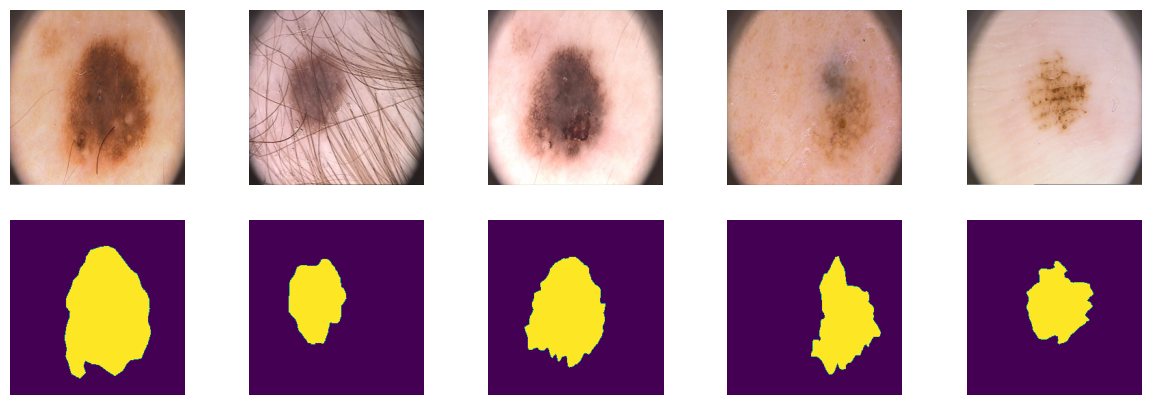

In [57]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, tiles))
for i in range(tiles):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [58]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

#### PyTorch DataLoader

In [59]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [60]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [61]:
# функция подсчета числа гиперпараметров
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [62]:
# функция подсчета числа сверточных слоев
def count_conv_layers(model):
    conv_count = sum(1 for m in model.modules() if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)))
    return conv_count

In [63]:
def tprint(message,verb=True):   
    import requests    # подробнее об этом: https://pythonist.ru/otpravka-soobshhenij-v-telegram-pri-pomoshhi-python/
    TOKEN = "5979454825:AAH8n7awvogIwLyHMk_zeqfVq92n_54e4Bs" # Мой токен бота для уведомлений
    chat_id = "232987571"                                    # Мой ID 
    url = f"https://api.telegram.org/bot{TOKEN}/sendMessage?chat_id={chat_id}&text={message}"
    requests.get(url).json() # отправка сообщения
    if verb:
        print(message)

# Реализация различных архитектур:
Задача: написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

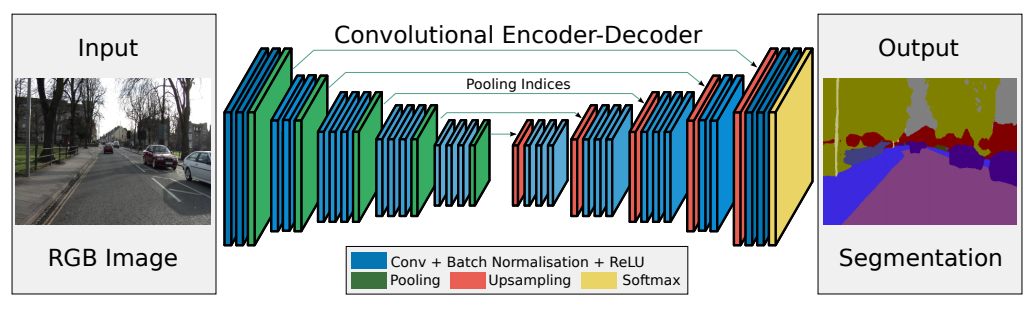

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [65]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.in_channels  = 3
        self.out_channels = 1 # если правильно понял
        
        # Псевдо-слой пулинга (для всех операций пулинга)
        self.pool   = nn.MaxPool2d( kernel_size=2, stride =2, return_indices= True)  
        
        # Псевдо-слой unpooling-а (upsample), то есть увеличения размера изображения, 
        # который будет использовать индексы, полученные из операций пулинга
        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        
        
        # ENCODER (downsampling)
        self.enc_conv0 = nn.Sequential( 
            nn.Conv2d( self.in_channels, 64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d( 64, 64, kernel_size = 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
         
        # 256 -> 128
        self.enc_conv1 = nn.Sequential( 
            nn.Conv2d( 64, 128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d( 128, 128, kernel_size = 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )        
        # 128 -> 64        
        self.enc_conv2 = nn.Sequential( 
            nn.Conv2d( 128, 256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d( 256, 256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d( 256, 256, kernel_size = 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        # 64 -> 32
        self.enc_conv3 = nn.Sequential( 
            nn.Conv2d( 256, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d( 512, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d( 512, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        # 32 -> 16

        
        
        # BOTTLENECK START ***                                                 BOTTLENECK START
        self.bottleneck_conv_down = nn.Sequential( 
            nn.Conv2d( 512, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d( 512, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d( 512, 512, kernel_size = 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        self.bottleneck_conv_up = nn.Sequential( 
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()            
        )
        # BOTTLENECK END ***                                                 BOTTLENECK END
        

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, self.out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(self.out_channels)
        )

    def forward(self, x):
        
        #print(f"x.shape, type = {x.shape}, {type(x)}")
        # encoder
        e0, idx0 = self.pool( self.enc_conv0( x) ) # 256 -> 128
        e1, idx1 = self.pool( self.enc_conv1(e0) ) # 128 -> 64
        e2, idx2 = self.pool( self.enc_conv2(e1) ) # 64  -> 32  256
        e3, idx3 = self.pool( self.enc_conv3(e2) ) # 32  -> 16  512

        # bottleneck
        bcd        = self.bottleneck_conv_down( e3 )
        bcd_p, idx = self.pool( bcd )
        bcu_up     = self.unpool(bcd_p, idx)
        bcu        = self.bottleneck_conv_up( bcu_up )
                
        # decoder
        u0 = self.unpool( bcu, idx3 ) 
        d0 = self.dec_conv0( u0 )
        u1 = self.unpool( d0, idx2 )
        d1 = self.dec_conv1( u1 )
        u2 = self.unpool( d1, idx1)
        d2 = self.dec_conv2( u2 )
        u3 = self.unpool( d2, idx0)
        d3 = self.dec_conv3( u3 )  # no activation
        
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Объявим функцию подсчета метрики Intersection over Union.

In [66]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, thresholded=True):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded_iou = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    if thresholded:
        return thresholded_iou 
    else:
        return iou

Заметим что мы также можем использовать не просто обычную метрику IoU, а метрику с увеличением чувствительности (thresholded) при переходных значениях вокруг 0.5. Но так как у нас не было требования использовать какой-либо конкретный вариант, выберем простую метрику IoU

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [67]:
def bce_loss(y_real, y_pred):
    epsilon = 1e-7

    L = torch.mean( 
        y_pred - y_real* y_pred + torch.log( 1 + torch.exp( -y_pred) + epsilon)
    )
    return L

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [68]:
def predict(model, data,measure_time=False):
    preds = []
    
    curr_device = str([param for name, param in model_segnet_base.named_parameters()][0].device)    
    if curr_device != DEVICE:
        model=model.to(DEVICE)    
    
    if measure_time:
        starttime = time()
        
    model.eval()  # testing mode
    with torch.no_grad():
        for X_batch, _ in data:
            X_batch = X_batch.to(DEVICE)
            pred_batch = model(X_batch)
            pred_batch = pred_batch.cpu()
            preds.append(pred_batch)

    if measure_time:
        pred_time = time() - starttime
        
    if curr_device != DEVICE:
        model=model.to(curr_device)    

    preds = torch.cat(preds, dim=0)
    
    if measure_time:
        return preds, pred_time
    else:
        return preds

In [69]:
def score_model(model, metric, data, thresholded=True):
    model=model.to(DEVICE)
    model.eval()  # testing mode

    scores = 0
    for X_batch, Y_label in data:
        
        X_batch = X_batch.to(DEVICE)
        Y_label = Y_label.to(DEVICE)
        
        #<TODO>
        with torch.no_grad():
            Y_pred = model(X_batch)
            Y_pred = F.sigmoid(Y_pred)
            Y_pred = (Y_pred >= 0.5).float()
            
        if thresholded:
            scores += metric(Y_pred, Y_label).mean().item()
        else:
            scores += metric(Y_pred, Y_label, thresholded=False).mean().item()
        
        X_batch = X_batch.cpu()
        Y_label = Y_label.cpu()
        del X_batch, Y_label

    model=model.cpu()
    torch.cuda.empty_cache()
    
    return scores/len(data)

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

<B>Замечание: </B>
Так как по условию задачи мы должны обучать до сходимости, нужно определить критерий сходимости. Будем считать что модель свелась до приемлемого уровня, если в течение n_conv (по-умолчанию 20) эпох значение loss-функции не уменьшилось.

In [70]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, n_conv=20,save_model=False,savename="lastmodel",folder_for_models="models"):
    """
    Обучение переданной модели с отрисовкой промежуточных наглядных примеров карт сегментации
    
    Параметры:
        model    - модель
        opt      - оптимизатор
        loss_fn  - функция ошибок
        epochs   - количество эпох
        data_tr  - dataloader обучающих данных
        data_val - dataloader валидационных данных
        n_conv   - критерий сходимости. Если функция ошибок в течение этого числа не уменьшилась
                   считаем что обучение завершено (по умолчанию = 20)
        save_model - если функция ошибки стала ниже лучшего значения сохраняем модель в файл
        save_name, folder_for_models  - при сохранении модели имя будет ./folder_for_models/save_model
                                        по умолчанию savename = "lastmodel",
                                                     folder_for_models = "models"
        
    """
    X_val, Y_val = next(iter(data_val))
    
    
    # Критерий сходимости
    # Будем считать что модель больше не может улучшить результат, если она в течение n_conv эпох
    # не улучшила валидационную метрику
    best_metric = 1
    max_tries   = n_conv
    i_tries     = 0
    
    # Добавим "контейнеры" для сохранения статистики
    history = []
    train_times = []
    val_times = []    

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        start_time = time() 
        avg_loss = 0
        model = model.to(DEVICE)
        model.train()  # train mode        
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_batch, Y_pred) 
            loss.backward() 
            opt.step() 

            # Расчет Loss для обучения
            avg_loss += loss / len(data_tr)
            
            # чистка памяти
            X_batch = X_batch.to('cpu')
            Y_batch = Y_batch.to('cpu')
            Y_pred  = Y_pred.to('cpu')
            del X_batch, Y_batch, Y_pred
            torch.cuda.empty_cache()
        train_times.append(time() - start_time)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_val.to(DEVICE)).detach().cpu() # Перенос из памяти GPU в CPU
        
        # определение сходимости
        start_time = time() 
        avg_loss_val = 0
        for Xv_batch, Yv_batch in data_val:
            # data to device
            Xv_batch = Xv_batch.to(DEVICE)
            Yv_batch = Yv_batch.to(DEVICE)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            with torch.set_grad_enabled(False):
                Yv_pred = model.forward(Xv_batch)
                loss_val = loss_fn(Yv_batch, Yv_pred) # forward-pass

            # Расчет функции ошибки для валидации
            avg_loss_val += loss_val / len(data_tr)
            
            if avg_loss_val > best_metric:
                best_wts    = model.state_dict()
                                
                if save_model == True:
                    state_dict_filename = f"{savename}_best.pth"
                    if not os.path.exists(folder_for_models):
                        os.makedirs(folder_for_models)
                    torch.save(best_wts, f"./{folder_for_models}/{state_dict_filename}")

            
            # чистка памяти
            Xv_batch = Xv_batch.to('cpu')
            Yv_batch = Yv_batch.to('cpu')
            Yv_pred  = Yv_pred.to('cpu')
            del Xv_batch, Yv_batch, Yv_pred
            torch.cuda.empty_cache()
        val_times.append(time() - start_time)
        toc = time()

        # Проверка на сходимость 
        if avg_loss_val < best_metric:
            best_metric = avg_loss_val
            i_tries = 0
        else:
            i_tries += 1
            
        # Если в течение max_tries эпох метрика не улучшилась то выходим
        if i_tries >= max_tries:
            break
            
        # Сохраняем статистику
        score_train = score_model(model, iou_pytorch, data_tr )
        score_val   = score_model(model, iou_pytorch, data_val)
        history.append((avg_loss.cpu(), avg_loss_val.cpu(), train_times, val_times, score_train, score_val))
        

        # Визуализация
        clear_output(wait=True)
        for k in range(tiles):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f, val_loss: %f (%d попытка, %d попыток без улучшений метрики до выхода)' % (epoch+1, epochs, avg_loss, avg_loss_val,i_tries,(max_tries-i_tries)))
        plt.show()
        
    
    return best_wts, history

## Основной момент: обучение


In [71]:
model_segnet_base = SegNet()

In [72]:
in_channels  = 3
out_channels = 1

Так как исследование проводится в области медицины, нам желательна максимальная точность. Потому будем брать большое число эпох, и будем подолгу ожидать улучшения метрики.

In [73]:
count_parameters(model_segnet_base)

29443587

In [74]:
count_conv_layers(model_segnet_base)

26

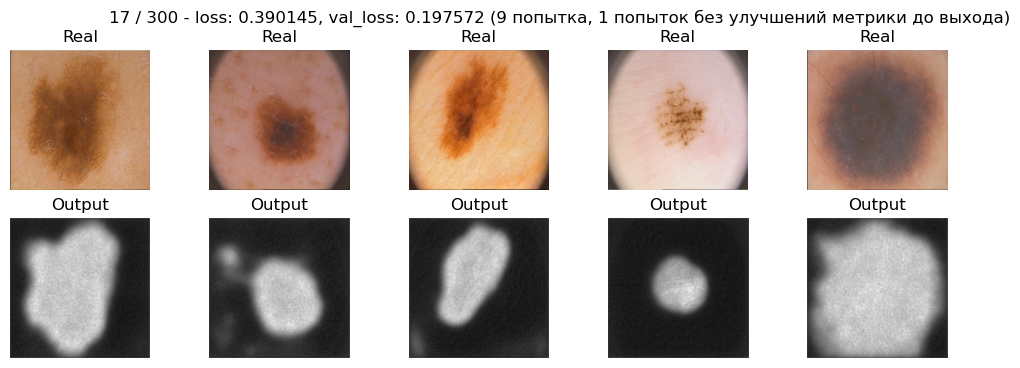

* Epoch 18/300
loss: 0.393341


In [75]:
model_segnet_base = model_segnet_base.to(DEVICE)

max_epochs = 300 
optim =  torch.optim.Adam(model_segnet_base.parameters(),betas=(0.990,0.999),lr=0.00005) 
best_wts_segnet_base, history_segnet_base = train(model_segnet_base, 
                                                  optim, 
                                                  bce_loss, 
                                                  max_epochs, 
                                                  data_tr, 
                                                  data_val,
                                                  n_conv=10,
                                                  save_model=True,
                                                  savename="segnet_base",
                                                  folder_for_models="models")
last_wts_segnet_base = model_segnet_base.state_dict()
model_segnet_base.load_state_dict(best_wts_segnet_base)

model_segnet_base.cpu()
torch.cuda.empty_cache()

In [76]:
score_model(model_segnet_base, iou_pytorch, data_val)

0.656000018119812

Ответьте себе на вопрос: не переобучается ли моя модель?

<B>Ответ</B>: немного переобучается, а почему - см. раздел "Отчет"

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

 В данном разделе будем имплементировать две функции потерь:
 DICE и Focal loss.

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$


In [77]:
def dice_loss(y_real, y_pred):
    # Константа для защиты от деления на ноль
    epsilon = 1e-5
    
    num = torch.sum(2 * y_real * y_pred)
    den = torch.sum( y_real + y_pred )
    res = 1 - (1/(256*256)) * torch.mean( num / (den + epsilon))
    return res

Проводим тестирование:

In [78]:
model_dice = SegNet()

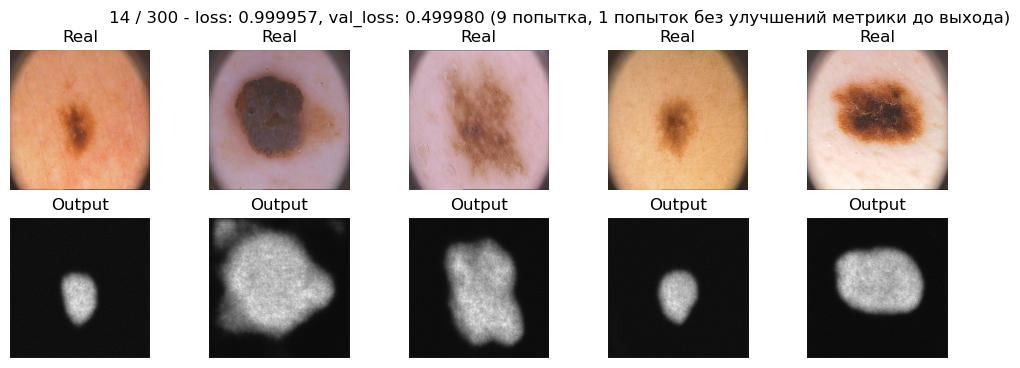

* Epoch 15/300
loss: 0.999956


In [79]:
torch.cuda.empty_cache()
model_dice = model_dice.to(DEVICE)

# Так же как и ранее, поставим число эпох и попыток улучшить метрику побольше
max_epochs = 300
optimaizer = torch.optim.Adam(model_dice.parameters(),betas=(0.990,0.999),lr=0.00005) 

best_wts_segnet_dice, history_segnet_dice = train(model_dice, 
                                                  optimaizer, 
                                                  dice_loss, 
                                                  max_epochs, 
                                                  data_tr, 
                                                  data_val, 
                                                  n_conv=10,
                                                  save_model=True,
                                                  savename="segnet_dice",
                                                  folder_for_models="models")
last_wts_segnet_dice = model_dice.state_dict()
model_dice.load_state_dict(best_wts_segnet_dice)

# Переносим модель из памяти GPU для освобождения памяти
model_dice = model_dice.cpu()
torch.cuda.empty_cache()

In [80]:
score_model(model_dice, iou_pytorch, data_val)

0.6940000057220459

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому будем применять весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [81]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    sigma_y_pred = F.sigmoid(y_pred)
    
    loss = -torch.sum( (1 - sigma_y_pred)**gamma * y_real * torch.log( torch.clamp(sigma_y_pred,eps) )  +  (1-y_real)*torch.log( torch.clamp( 1 - sigma_y_pred,eps)  ) )
    return loss

In [82]:
torch.cuda.empty_cache()

In [83]:
model_focal = SegNet()

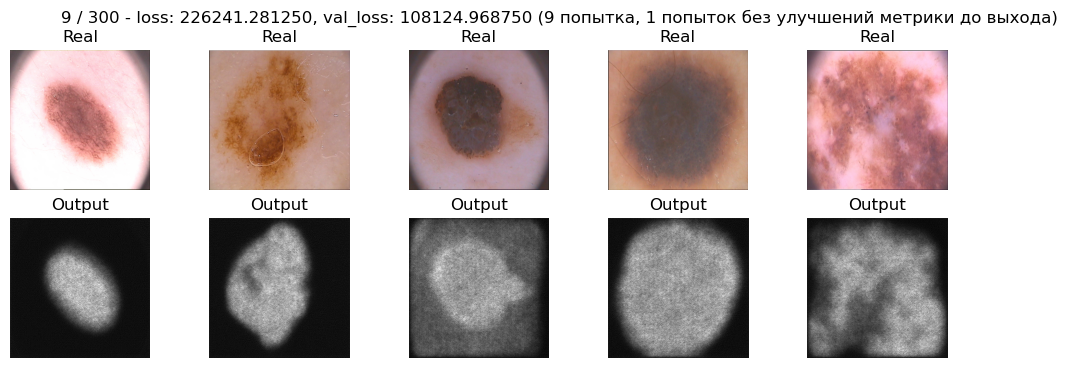

* Epoch 10/300
loss: 222676.796875


In [84]:
model_focal = model_focal.to(DEVICE)

max_epochs = 300
optim_focal = torch.optim.Adam(model_focal.parameters(),betas=(0.990,0.999),lr=0.00005) 

best_wts_segnet_focal, history_segnet_focal = train(model_focal, 
                                                    optim_focal, 
                                                    focal_loss, 
                                                    max_epochs, 
                                                    data_tr, 
                                                    data_val, 
                                                    n_conv=10,
                                                    save_model=True,
                                                    savename="segnet_focal",
                                                    folder_for_models="models")
last_wts_segnet_focal = model_focal.state_dict()
model_focal.load_state_dict(best_wts_segnet_focal)

# Перенесение модели из GPU, чистка памяти
model_focal = model_focal.cpu()
torch.cuda.empty_cache()

In [85]:
score_model(model_focal, iou_pytorch, data_val)

0.5700000286102295

----------------------------------------------------------------------------------------------

## Дополнение. Мир сегментационных лоссов



В качестве дополнительной метрики для оценки выбираем Correlation Maximized Structural Similarity Loss (CMSS), согласно вышеобозначенной статье.

In [86]:
def ssim(img1, img2, win_size=11, K1=0.01, K2=0.03):     # 0.43
    '''
    Эта функция вычисления индекса структурного сходства изображений 
    (Structural similarity index)
    
    Входящие данные:
        img1 - первое изображение для сравнения
        img2 - второе изображение для сравнения
        win_size - размер окна (региона) для расчета среднего 
                   (меньшее значение - для локальных оценок, 
                    большее значение - для глобальных оценок)
        K1, К2 - константы для защиты от деления на ноль, 
                 влияют на вычисления структурного сходства
    '''
    L = 1  # Максимальное значение яркости в изображении (например, 1 для изображений в диапазоне [0, 1])
    
    C1 = (K1 * L) ** 2 # константа 1 для защиты от деления на ноль. Добавляется к дисперсии в знаменателе
    C2 = (K2 * L) ** 2 # константа 2 для защиты от деления на ноль. Добавляется к дисперсии в знаменателе
    
    # средние значения 
    mu1 = torch.nn.functional.avg_pool2d(img1, win_size, padding=win_size//2, stride=1) # вычисляем средние значения
    mu2 = torch.nn.functional.avg_pool2d(img2, win_size, padding=win_size//2, stride=1) # вычисляем средние значения
    
    mu1_sq = mu1 ** 2  
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    
    sigma1_sq = torch.nn.functional.avg_pool2d(img1 * img1, win_size, padding=win_size//2, stride=1) - mu1_sq  # вычисляем дисперсии
    sigma2_sq = torch.nn.functional.avg_pool2d(img2 * img2, win_size, padding=win_size//2, stride=1) - mu2_sq  # вычисляем дисперсии
    sigma12   = torch.nn.functional.avg_pool2d(img1 * img2, win_size, padding=win_size//2, stride=1) - mu1_mu2 # вычисляем дисперсию 
                                                                                                               # ковариации изображений
    
    num = (2 * mu1_mu2 + C1) * (2 * sigma12 + C2)               # числитель
    den = (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2) # знаменатель
    
    ssim_map = num / den  # Вычисление карты SSIM
    
    return torch.mean(ssim_map)

def cmss_loss(img1, img2, weight=0.5):
    '''
    Эта функция вычисления функции ошибок на основе индекса SSI
    (Structural similarity index)
    
    Входящие данные:
        img1 - первое изображение для сравнения
        img2 - второе изображение для сравнения
        weight - коэффициент регуляризации для управления влияния индекса SSI
                 Определет баланс между вкладом SSI и Correlation Coefficient Maximized Loss
    '''
    
    ssim_value = ssim(img1, img2)
    ccml_loss = torch.abs(torch.mean(img1) - torch.mean(img2)) # Вычисление Correlation Coefficient Maximized Loss
    
    cmss_loss = weight * (1 - ssim_value) + (1 - weight) * ccml_loss
    
    return cmss_loss

In [87]:
torch.cuda.empty_cache()

In [415]:
batch_size_cmss = 10
data_tr_cmss = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size_cmss, shuffle=True, num_workers=8)
data_val_cmss = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_cmss, shuffle=True, num_workers=8)
data_ts_cmss = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size_cmss, shuffle=True, num_workers=8)

In [416]:
model_cmss = SegNet()

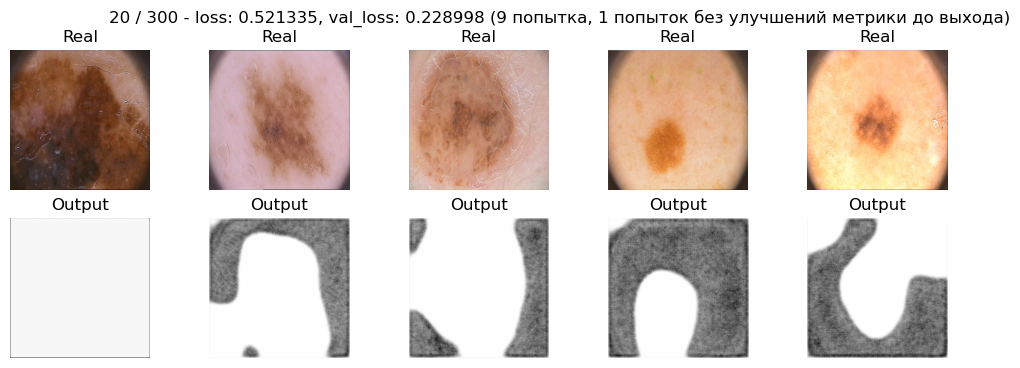

* Epoch 21/300
loss: 0.520590


In [417]:
model_cmss = model_cmss.to(DEVICE)

max_epochs = 300
optim_cmss = torch.optim.Adam(model_cmss.parameters(),betas=(0.990,0.999),lr=0.00005)  
best_wts_segnet_smss, history_segnet_cmss   = train(model_cmss, 
                                                    optim_cmss, 
                                                    cmss_loss, 
                                                    max_epochs, 
                                                    data_tr_cmss, 
                                                    data_val_cmss,
                                                    n_conv=10,
                                                    save_model=True,
                                                    savename="segnet_cmss",
                                                    folder_for_models="models")

# Перенесение модели из GPU, чистка памяти
model_cmss = model_cmss.cpu()
torch.cuda.empty_cache()

In [418]:
score_model(model_cmss, iou_pytorch, data_val)

0.16800000593066217

<B>Промежуточный вывод</B>: Метрика показывает не очень хорошее оценочное значения IoU. Похоже что это просто не очень удачный вариант в приложении к выбранной задаче, так как задача этой метрики выделять класс на фоне остальных. А для кожных нарушений в текущей задаче есть только один класс и его границы размыты.

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

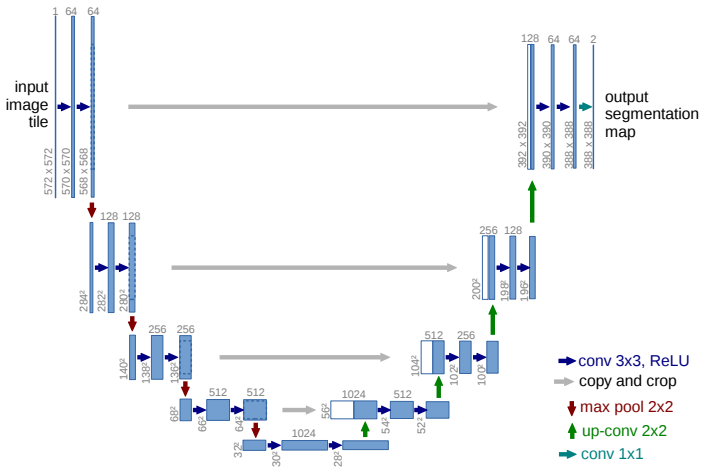

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [52]:
# Функция для reflection padding перед конволюцией (реализация overlap-tile strategy из лекции и статьи)
# То есть отражение внешней рамки карты картинки/карт активации на соседний внешний пиксель

def reflection_pad(x):
    return F.pad(x, (1, 1, 1, 1), 'reflect')

In [290]:
class double_conv_unet1(nn.Module):
    def __init__(self, in_channels, out_channels,use_overlap_tile = True):
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.use_overlap_tile = use_overlap_tile
        self.conv1p = nn.Conv2d( self.in_channels,  self.out_channels, kernel_size = 3, padding=1)
        self.conv2p = nn.Conv2d( self.out_channels, self.out_channels, kernel_size = 3, padding=1)
        self.act  = nn.ReLU()
        
    def forward(self,x):
        x = self.act(self.conv1p(x))
        x = self.act(self.conv2p(x))
        return x

class DOWN_unet1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = double_conv_unet1(self.in_channels, self.out_channels)
        self.downscale  = nn.MaxPool2d( kernel_size=2, stride =2)
        
    def forward(self,x):
        x = self.conv(x)
        d = self.downscale(x)
        return x, d

class UP_unet1(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=(2,2) , mode='nearest')
        self.conv = double_conv_unet1(in_channels, out_channels)            
        self.conv_prepare = nn.Conv2d(in_channels,out_channels,kernel_size=1)

    def forward(self, x, skip_x):
        x = self.up(x)
        x = self.conv_prepare(x)
        new_x = torch.cat([skip_x, x], dim=1)
        return self.conv(new_x)

class UNet1(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.in_channels  = 3
        self.out_channels = 1
        
        # ENCODER (downsampling)        
        self.down0 = DOWN_unet1(self.in_channels,64)
        self.down1 = DOWN_unet1(64,128)
        self.down2 = DOWN_unet1(128,256)
        self.down3 = DOWN_unet1(256,512)

        # bottleneck
        self.bottleneck_conv = double_conv_unet1(512,1024)

        # decoder (upsampling)
        self.up0 = UP_unet1(1024, 512)
        self.up1 = UP_unet1(512, 256)
        self.up2 = UP_unet1(256, 128)
        self.up3 = UP_unet1(128, 64)
       
        self.classifier = nn.Conv2d(64, 1, kernel_size=1)
        

        
    def forward(self, x):
        # encoder        
        e0, x = self.down0( x)
        e1, x = self.down1(x)
        e2, x = self.down2(x)
        e3, x = self.down3(x)

        # bottleneck
        b = self.bottleneck_conv(x)

        us0 = self.up0(b,  e3)
        us1 = self.up1(us0,e2)
        us2 = self.up2(us1,e1)
        us3 = self.up3(us2,e0)
        classifier = self.classifier( us3)

        return classifier

In [291]:
batch_size_unet1_train = 5
batch_size_unet1_val = 5
data_tr_unet1 = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size_unet1_train, shuffle=True, num_workers=8)
data_val_unet1 = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet1_val, shuffle=True, num_workers=8)
data_ts_unet1 = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size_unet1_val, shuffle=True, num_workers=8)

In [347]:
unet1_model = UNet1()

In [348]:
count_parameters(unet1_model)

28942785

In [349]:
count_conv_layers(unet1_model)

23

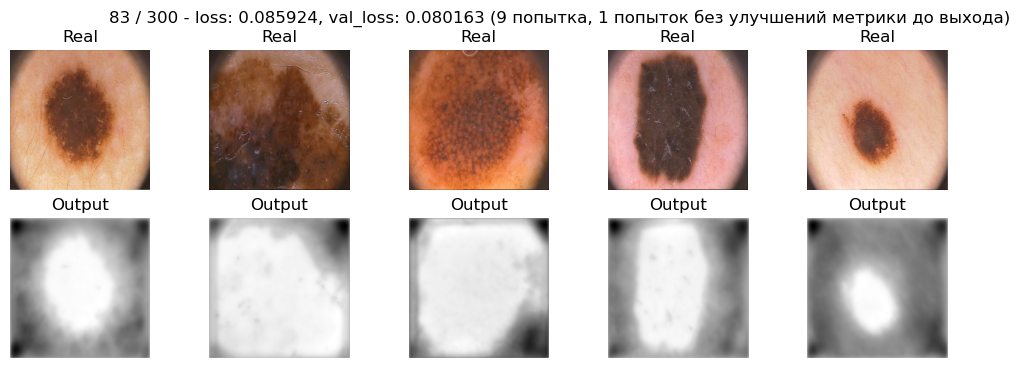

* Epoch 84/300
loss: 0.082595


In [350]:
epochs_unet1 = 300
unet1_model = unet1_model.cpu()
torch.cuda.empty_cache()
unet1_model = unet1_model.to(DEVICE)
opt_unet1   = torch.optim.Adam(unet1_model.parameters(),betas=(0.990,0.999),lr=0.00005) 

best_wts_unet1, history_unet1 = train(unet1_model, 
                                      opt_unet1, 
                                      bce_loss, 
                                      epochs_unet1, 
                                      data_tr_unet1, 
                                      data_val_unet1,
                                      n_conv=10,
                                      save_model=True,
                                      savename="unet1",
                                      folder_for_models="models")
last_wts_unet1 = unet1_model.state_dict()

unet1_model.load_state_dict(best_wts_unet1)
unet1_model = unet1_model.cpu()

In [351]:
score_model(unet1_model, iou_pytorch, data_val_unet1)

0.7280000388622284

In [352]:
tprint('unet1 trained') # Отправка в telegram сообщения о выполнении текущего этапа расчета

unet1 trained


Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Заменяем max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [312]:
class double_conv_unet2(nn.Module):
    def __init__(self, in_channels, out_channels,use_overlap_tile = True): 
        super().__init__()
        self.in_channels  = in_channels
        self.out_channels = out_channels
        self.use_overlap_tile = use_overlap_tile
        self.conv1ot = nn.Conv2d( self.in_channels,  self.out_channels, kernel_size = 3)
        self.conv2ot = nn.Conv2d( self.out_channels, self.out_channels, kernel_size = 3)
        self.act  = nn.ReLU()
        
    def forward(self,x):
        x = self.act(self.conv1ot(reflection_pad(x)))
        x = self.act(self.conv2ot(reflection_pad(x)))        
        return x


class DOWN_unet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = double_conv_unet1(self.in_channels, self.out_channels)
        self.downscale  = nn.Conv2d(out_channels,out_channels,stride=2,kernel_size=3,padding=1)
    def forward(self,x):
        x = self.conv(x)
        d = self.downscale(x)
        return x, d

class UP_unet2(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = double_conv_unet1(in_channels, out_channels)            

    def forward(self, x, skip_x):
        x = self.up(x)
        
        new_x = torch.cat([skip_x, x], dim=1)
        return self.conv(new_x)
    
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.in_channels  = 3
        self.out_channels = 1
       
        # ENCODER (downsampling)        
        self.down0 = DOWN_unet2(self.in_channels,64)
        self.down1 = DOWN_unet2(64,128)
        self.down2 = DOWN_unet2(128,256)
        self.down3 = DOWN_unet2(256,512)

        # bottleneck
        self.bottleneck_conv = double_conv_unet1(512,1024)

        # decoder (upsampling)
        self.up0 = UP_unet2(1024, 512)
        self.up1 = UP_unet2(512, 256)
        self.up2 = UP_unet2(256, 128)
        self.up3 = UP_unet2(128, 64)
       
        self.classifier = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        # encoder        
        e0, x = self.down0( x)
        e1, x = self.down1(x)
        e2, x = self.down2(x)
        e3, x = self.down3(x)

        # bottleneck
        b = self.bottleneck_conv(x)

        # decoder
        us0 = self.up0(b,  e3)
        us1 = self.up1(us0,e2)
        us2 = self.up2(us1,e1)
        us3 = self.up3(us2,e0)
        classifier = self.classifier( us3)

        return classifier

In [386]:
unet2_model = UNet2()

In [387]:
count_parameters(unet2_model)

34166145

In [388]:
count_conv_layers(unet2_model)

27

In [384]:
batch_size_unet2 = 10
batch_size_unet2_val = 10
data_tr_unet2 = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size_unet2, shuffle=True, num_workers=8)
data_val_unet2 = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_unet2_val, shuffle=True, num_workers=8)
data_ts_unet2 = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size_unet2_val, shuffle=True, num_workers=8)

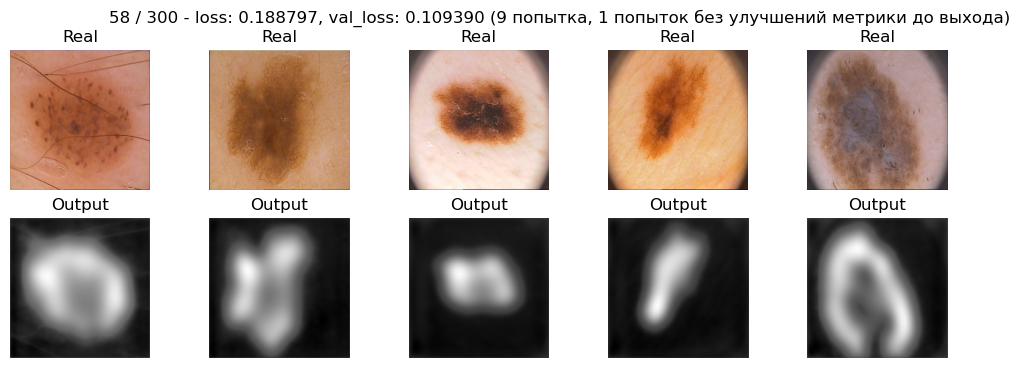

* Epoch 59/300
loss: 0.193385


In [389]:
epochs_unet2 = 300
unet2_model = unet2_model.cpu()
torch.cuda.empty_cache()
unet2_model = unet2_model.to(DEVICE)
opt_unet2 = torch.optim.Adam(unet2_model.parameters(),betas=(0.990,0.999),lr=0.00005) 

best_wts_unet2, history_unet2 = train(unet2_model, 
                                      opt_unet2, 
                                      bce_loss, 
                                      epochs_unet2, 
                                      data_tr_unet2, 
                                      data_val_unet2,
                                      n_conv=10,
                                      save_model=True,
                                      savename="unet1",
                                      folder_for_models="models")
last_wts_unet2 = unet2_model.state_dict()

unet2_model.load_state_dict(best_wts_unet2)
unet2_model = unet2_model.cpu()

In [390]:
score_model(unet2_model, iou_pytorch, data_val_unet1)

0.6560000240802765

In [492]:
tprint('unet 2 done') # Отправка в telegram сообщения о выполнении текущего этапа расчета

unet 2 done


Какая из моделей лучше?

<B>Ответ: </B> вывод о выборе модели см. в отчете.

# Отчет:

Постараемся ответить на вопрос, какая из моделей наиболее практична в применении

&nbsp;

In [427]:
def unpack_history(history):
    tloss, vloss, ttime, vtime, tscore, vscore = zip(*history)
    tloss = [tl.cpu().detach().numpy() for tl in tloss]
    vloss = [vl.cpu().detach().numpy() for vl in vloss]
    
    ttimetotal = np.sum(ttime)
    vtimetotal = np.sum(vtime)
    ttime = [np.mean(t) for t in ttime]
    vtime = [np.mean(v) for v in vtime]
    
    return tloss, vloss, ttime, vtime, ttimetotal, vtimetotal, tscore, vscore    

In [428]:
def min_max_normalize(numbers):
    
    normalized_numbers = (numbers - np.min(numbers)) / (np.max(numbers) - np.min(numbers))
    return normalized_numbers

In [429]:
train_loss_sbase, val_oss_sbase, train_time_sbase, val_time_sbase, tttotal_sbase, vttotal_sbase, train_score_sbase, val_score_sbase      = unpack_history(history_segnet_base) 
train_loss_sdice, val_oss_sdice, train_time_sdice, val_time_sdice, tttotal_sdice, vttotal_sdice, train_score_sdice, val_score_sdice      = unpack_history(history_segnet_dice)
train_loss_sfocal, val_oss_sfocal, train_time_sfocal, val_time_sfocal, tttotal_sfocal, vttotal_sfocal, train_score_sfocal, val_score_sfocal= unpack_history(history_segnet_focal)
train_loss_scmss, val_oss_scmss, train_time_scmss, val_time_scmss, tttotal_scmss, vttotal_scmss, train_score_scmss, val_score_scmss      = unpack_history(history_segnet_cmss)
train_loss_unet1, val_oss_unet1, train_time_unet1, val_time_unet1, tttotal_unet1, vttotal_unet1, train_score_unet1, val_score_unet1      = unpack_history(history_unet1)
train_loss_unet2, val_oss_unet2, train_time_unet2, val_time_unet2, tttotal_unet2, vttotal_unet2, train_score_unet2, val_score_unet2      = unpack_history(history_unet2)

&nbsp;

Заметим что так как обучение Unet согласно авторской статье требует некоторых условий (уменьшения выборки и увеличения значения момента для оптимизатора), обучение всех рассмотренных моделей для честности сравнений произведено на тех же значениях batch_size, learning rate и показателях момента (инерции) оптимизатора.<BR><BR>

<B>Постановка вопроса:</B><BR><BR>Вопросом для выяснения будет следующий - "Какая модель из рассмотренных является наиболее практичной?"<BR>
<BR>

Практичность модели будем оценивать на основании скорости обучения, скорости работы, точности предсказаний и стабильности.

<b>Скорость</B>

Оценка времени обучения и валидации

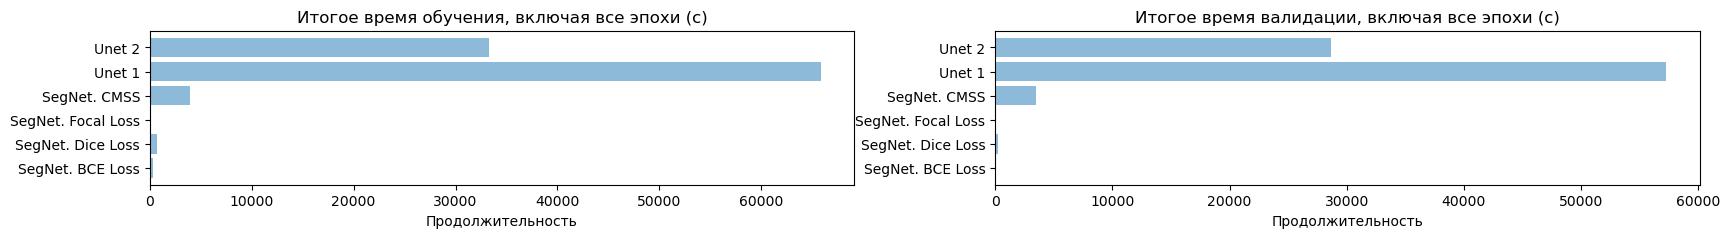

In [431]:
plt.figure(figsize=(20,2))
plt.subplot(1, 2, 1)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1', 'Unet 2')
values    = [ tttotal_sbase
             ,tttotal_sdice
             ,tttotal_sfocal
             ,tttotal_scmss
             ,tttotal_unet1
             ,tttotal_unet2]

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, variables)
plt.xlabel('Продолжительность')
plt.title('Итогое время обучения, включая все эпохи (с)')

plt.subplot(1, 2, 2)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1', 'Unet 2')
values    = [ vttotal_sbase
             ,vttotal_sdice
             ,vttotal_sfocal
             ,vttotal_scmss
             ,vttotal_unet1
             ,vttotal_unet2]

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, variables)
plt.xlabel('Продолжительность')
plt.title('Итогое время валидации, включая все эпохи (с)');



На этих диаграммах мы оцениваем общее время до сходимости моделей. Напомним что использовался лимит в 300 эпох, с batch_size = 10 (за исключением unet1, unet2, где использовался batch_size = 5). Обучение считалось завершенным если функция ошибки не уменьшалась 10 эпох подряд. Наблюдается огромная разница в сходимости для разных моделей и функций ошибок.

&nbsp;

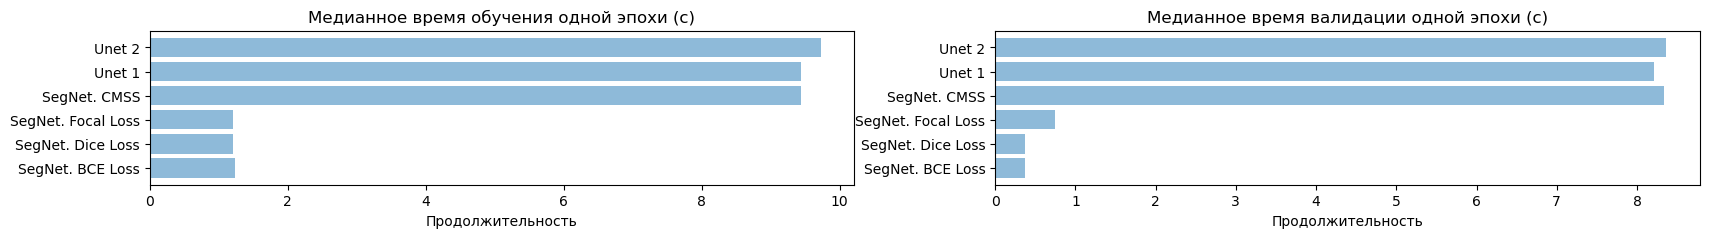

In [439]:
plt.figure(figsize=(20,2))
plt.subplot(1, 2, 1)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1', 'Unet 2')
values    = [ np.median(train_time_sbase)
             ,np.median(train_time_sdice)
             ,np.median(train_time_sfocal)
             ,np.median(train_time_scmss)
             ,np.median(train_time_unet1)
             ,np.median(train_time_unet2)]

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, variables)
plt.xlabel('Продолжительность')
plt.title('Медианное время обучения одной эпохи (с)')

plt.subplot(1, 2, 2)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1', 'Unet 2')
values    = [ np.median(val_time_sbase)
             ,np.median(val_time_sdice)
             ,np.median(val_time_sfocal)
             ,np.median(val_time_scmss)
             ,np.median(val_time_unet1)
             ,np.median(val_time_unet2)]

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, variables)
plt.xlabel('Продолжительность')
plt.title('Медианное время валидации одной эпохи (с)');



Время валидации эпохи как и время её обучения для Unet существенно больше чем для SegNet. Стоит проверить, какова разница в скорости предсказаний. так как например применении модели в связке с видеопотоком разница в скорости может фатально сказаться на практичности.

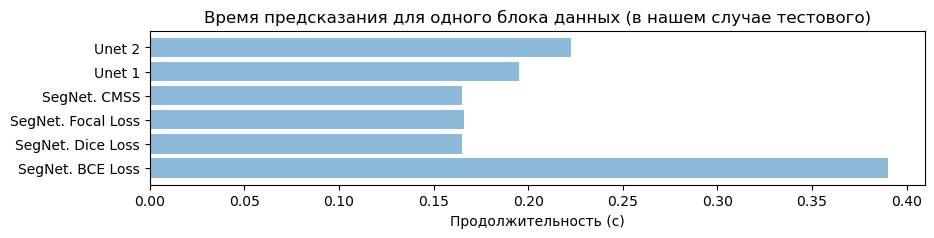

In [484]:
plt.figure(figsize=(10,2))
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1', 'Unet 2')
values    = [ predict(model_segnet_base,data_ts,measure_time=True)[1]
             ,predict(model_dice,data_ts,measure_time=True)[1]
             ,predict(model_focal,data_ts,measure_time=True)[1]
             ,predict(model_cmss,data_ts,measure_time=True)[1]
             ,predict(unet1_model,data_ts,measure_time=True)[1]
             ,predict(unet2_model,data_ts,measure_time=True)[1]]

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5)
plt.yticks(y_pos, variables)
plt.xlabel('Продолжительность (с)')
plt.title('Время предсказания для одного блока данных (в нашем случае тестового)');


Несмотря на длительное время валидации, время предсказания между Unet и SegNet отличается очень мало. Что нас полностью устраивает.


<BR>

<B>Точность предсказаний</B>

Посмотрим теперь на то, к каким результатам по метрике Intersection over union мы пришли.

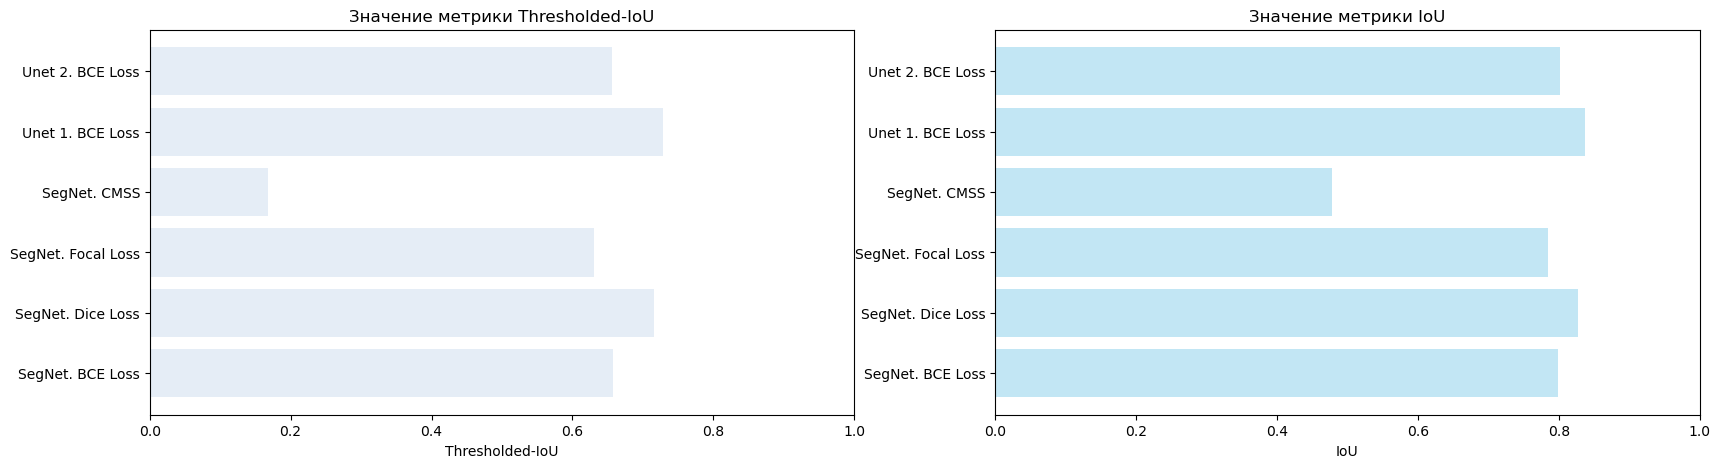

In [432]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1. BCE Loss', 'Unet 2. BCE Loss')
values    = [ score_model(model_segnet_base,iou_pytorch,data_val)
             ,score_model(model_dice,iou_pytorch,data_val)
             ,score_model(model_focal,iou_pytorch,data_val)
             ,score_model(model_cmss,iou_pytorch,data_val)
             ,score_model(unet1_model,iou_pytorch,data_val)
             ,score_model(unet2_model,iou_pytorch,data_val)]
plt.xlim(0, 1)

y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5, color='#CCDDEE')
plt.yticks(y_pos, variables)
plt.xlabel('Thresholded-IoU')
plt.title('Значение метрики Thresholded-IoU')


plt.subplot(1, 2, 2)
variables = ('SegNet. BCE Loss', 'SegNet. Dice Loss', 'SegNet. Focal Loss', 'SegNet. CMSS', 'Unet 1. BCE Loss', 'Unet 2. BCE Loss')
values    = [ score_model(model_segnet_base,iou_pytorch,data_val,thresholded=False)
             ,score_model(model_dice,iou_pytorch,data_val,thresholded=False)
             ,score_model(model_focal,iou_pytorch,data_val,thresholded=False)
             ,score_model(model_cmss,iou_pytorch,data_val,thresholded=False)
             ,score_model(unet1_model,iou_pytorch,data_val,thresholded=False)
             ,score_model(unet2_model,iou_pytorch,data_val,thresholded=False)]
plt.xlim(0, 1)
y_pos = np.arange(len(variables))

# Построение горизонтальной столбчатой диаграммы
plt.barh(y_pos, values, align='center', alpha=0.5, color='skyblue')
plt.yticks(y_pos, variables)
plt.xlabel('IoU')
plt.title('Значение метрики IoU');


Применение thresholded-варианта метрики IoU показывает чувствительность метрики на пороговых значениях. Видно что Unet1, обученный с помощью BCE Loss и SegNet, обученный с помощью Dice Loss дают наиболее высокие значения метрики IoU как для IoU с повышенной чувствительностью к границам, так и для обычной IoU-метрики.

<B>Стабильность</B>

С качеством предсказаний и скоростью определились. Посмотрим теперь на стабильность.

Text(0.5, 1.0, 'Изменение функции ошибок при валидации')

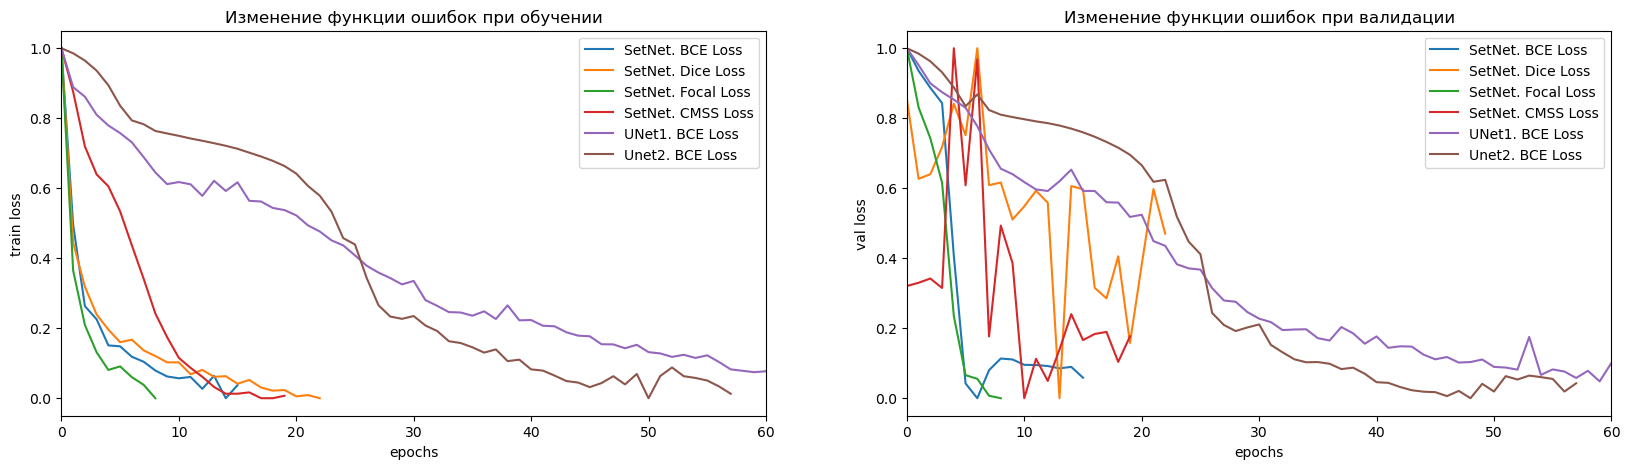

In [487]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) #, gridspec_kw={'width_ratios': [2, 3]})
plt.subplot(1, 2, 1)
plt.plot(min_max_normalize(train_loss_sbase), label="SetNet. BCE Loss")
plt.plot(min_max_normalize(train_loss_sdice), label="SetNet. Dice Loss")
plt.plot(min_max_normalize(train_loss_sfocal), label="SetNet. Focal Loss")
plt.plot(min_max_normalize(train_loss_scmss), label="SetNet. CMSS Loss")
plt.plot(min_max_normalize(train_loss_unet1), label="UNet1. BCE Loss")
plt.plot(min_max_normalize(train_loss_unet2), label="Unet2. BCE Loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("train loss")
plt.xlim(0, 60)
plt.title('Изменение функции ошибок при обучении')

plt.subplot(1, 2, 2)
plt.plot(min_max_normalize(val_oss_sbase), label="SetNet. BCE Loss")
plt.plot(min_max_normalize(val_oss_sdice), label="SetNet. Dice Loss")
plt.plot(min_max_normalize(val_oss_sfocal), label="SetNet. Focal Loss")
plt.plot(min_max_normalize(val_oss_scmss), label="SetNet. CMSS Loss")
plt.plot(min_max_normalize(val_oss_unet1), label="UNet1. BCE Loss")
plt.plot(min_max_normalize(val_oss_unet2), label="Unet2. BCE Loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("val loss")
plt.xlim(0, 60);
plt.title('Изменение функции ошибок при валидации')

Здесь мы сравниваем не сами функции ошибок (так как у них совершенно разные масштабы), а то как они уменьшаются. Для этого используем нормализованные значения функции ошибок (min/max scaling-ом).
На этих графиках наблюдаем изменение фунции ошибок при обучении наших моделей. Видим что:<BR>
- для SegNet функции ошибок гораздо более плавные на обучающей выборке и скачкообразные на валидационной. Что говорит о некотором переобучении моделей. Модель подстраивается под тренировочные данные и несколько теряет обобщающую способность. Для решения этой проблемы имеет смысл попробовать использовать регуляризацию, аугментацию, а лучшим вариантом был бы вариант с увеличением датасета.
- модели Unet учатся медленнее но гораздо стабильнее как при обучении, так и при валидации.<BR>

### Подведение итогов

Проведенные наблюдения показывают что значения метрик качества сегментации (здесь прежде всего имеем в виду IoU) близки у трёх лидирующих моделей - SegNet(DICE), Unet1(BCELoss) и Unet2(BCELoss). Учитывая то что в медицинском приложении высокая скорость предсказаний скорее всего не потребуется, та разница в скорости которую мы имеем между SegNet(DICE) и Unet 1/2 не представляется значимой.
При этом Точность Unet1 несколько выше, но что важно, Unet1 гораздо стабильнее.<BR>
Возможно что дообучение моделей на более крупном наборе размеченных данных или использование агументаций могло бы повлиять на результат таким образом чтобы SegNet показал себя стабильнее и выдавал лучшую метрику, но при том наборе данных что имеем, Unet будет нашим выборомм. Здесь обе модели Unet хорошо себя показали, веса дающие наилучшую метрику обнаружены у модели Unet1 что можно списать на случайность, так как Unet2 в целом по графику показывал лучшую тенденцию улучшения качества, так что предпочтение отдадим ему.

В качестве финальной точки проверим метрику выбранной модели тестовой выборке:

In [489]:
score_model(unet2_model,iou_pytorch,data_ts_unet2)

0.5540000319480896

In [491]:
score_model(unet2_model,iou_pytorch,data_ts_unet2,thresholded=False)

0.7548130869865417

Увеличение числа эпох, критерия сходимости, аугментации и что, самое главное, объема данных для обучения могут существенно повысить качество модели.

&nbsp;

&nbsp;

Спасибо за внимание и потраченное время<BR>
@varivodasergei - контакт на всякий случай